In [1]:
# importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
import seaborn as sns

In [2]:
# montando drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# importando base de dados
filePath = '/content/drive/My Drive/Process Quality Control - PLS project'
fileName = 'process_data.csv'
data = pd.read_csv(os.path.join(filePath, fileName))
data.head()

,solutionA_inletFlowRate,water_inletFlowRate,solutionB_inletFlowRate,componentA_inletConcentration,componentB_inletConcentration,solutionA_inletTemperature,water_inletTemperature,solutionB_inletTemperature,componentA_outletConcentration,componentB_outletConcentration,componentC_outletConcentration,outletTemperature
0,2.488026,7.022645,0.493385,7.415100,12.313350,29.232410,10.161989,29.204568,1.747784,0.414548,0.192728,96.089927
1,2.564250,7.210281,0.521194,7.001721,12.246920,30.321235,9.813532,29.937081,1.649414,0.431103,0.188865,95.193304
2,2.578252,7.356546,0.530302,7.039666,11.964474,29.647262,9.939467,30.877037,1.648039,0.433679,0.172601,88.922935
3,2.438043,6.534329,0.492974,7.097230,12.032390,29.074167,10.126576,30.156679,1.716432,0.403386,0.223285,108.955373
4,2.222003,6.377055,0.496884,7.185610,11.724253,31.573436,10.024570,28.878612,1.637008,0.403802,0.236659,114.179174


In [4]:
# checando informações dos dados
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   solutionA_inletFlowRate         5000 non-null   float64
 1   water_inletFlowRate             5000 non-null   float64
 2   solutionB_inletFlowRate         5000 non-null   float64
 3   componentA_inletConcentration   5000 non-null   float64
 4   componentB_inletConcentration   5000 non-null   float64
 5   solutionA_inletTemperature      5000 non-null   float64
 6   water_inletTemperature          5000 non-null   float64
 7   solutionB_inletTemperature      5000 non-null   float64
 8   componentA_outletConcentration  5000 non-null   float64
 9   componentB_outletConcentration  5000 non-null   float64
 10  componentC_outletConcentration  5000 non-null   float64
 11  outletTemperature               5000 non-null   float64
dtypes: float64(12)
memory usage: 468.9

Verifica-se qur todos os dados obtidos são da categoria númerico e que também não há valores nulos presentes.

O conjunto de dados é constituído de 11 variáveis de processo, sendo 7 delas são variáveis de controle (*input*) e as 4 restantes, variáveis de saída (*output*).

São variáveis de entrada:
- vazão de solução A
- vazão de água
- vazão de solução B
- concentração de entrada do componente A
- concentração de entrada do componente B
- temperatura de entrada da solução A
- temperatura de entrada de água
- temperatura de entrada da solução B

São variáveis de saída:
- concentração de saída do componente A
- concentração de saída do componente B
- concentração de saída do componente C
- temperatura de saída


## **1. Objetivo do Estudo**

No processo em estudo, estamos interessados no componente C, que é o que agrega valor. Sabendo que essa reação não é completa, deseja-se determinar qual a combinação de variáveis de entrada que possa oferecer maior concentração de componente C, levando-se em consideração o aspecto da segurança do processo.

Para tanto, um indicador será criado nessa base de dados, para expressar o desempenho do processo. Esse indicador é conhecido como *conversão*.

Lembrando a definição:

- *Conversão*: quanto do reagente limitante reagiu no processo, dado pela razão entre a diferença da concentração inicial e final, e a concentração inicial

In [5]:
# criação das colunas de indicadores
data['X'] = (data['componentB_inletConcentration']-data['componentB_outletConcentration'])/data['componentB_inletConcentration']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   solutionA_inletFlowRate         5000 non-null   float64
 1   water_inletFlowRate             5000 non-null   float64
 2   solutionB_inletFlowRate         5000 non-null   float64
 3   componentA_inletConcentration   5000 non-null   float64
 4   componentB_inletConcentration   5000 non-null   float64
 5   solutionA_inletTemperature      5000 non-null   float64
 6   water_inletTemperature          5000 non-null   float64
 7   solutionB_inletTemperature      5000 non-null   float64
 8   componentA_outletConcentration  5000 non-null   float64
 9   componentB_outletConcentration  5000 non-null   float64
 10  componentC_outletConcentration  5000 non-null   float64
 11  outletTemperature               5000 non-null   float64
 12  X                               50

## **2. Análise Exploratória de Dados**

In [6]:
def control_chart(data, var_name, n = 5):
  # função que plota as cartas de controle da média e amplitudes para determinado
  # processo, com base em uma amostragem de n pontos por minuto

  to_monitor = pd.DataFrame(data[var_name], columns=[var_name])

  # definição do dicionário de valores de constantes
  d2_dict = {2: 1.128, 3: 1.693, 4: 2.059, 5: 2.326, 6: 2.534, 7: 2.704,
            8: 2.847, 9: 2.970, 10: 3.078, 11: 3.173, 12: 3.258, 13: 3.336,
            14: 3.407, 15: 3.472}
  d3_dict = {2: 0.853, 3: 0.888, 4: 0.880, 5: 0.864, 6: 0.848, 7: 0.833,
            8: 0.820, 9: 0.808, 10: 0.797, 11: 0.787, 12: 0.778, 13: 0.770,
            14: 0.763, 15: 0.756}

  # agrupamento dos monitoramentos e cálculo dos valores da carta
  to_monitor_mean = to_monitor.groupby(to_monitor.index//n).agg({var_name:'mean'})
  to_monitor_max = to_monitor.groupby(to_monitor.index//n).agg({var_name:'max'})
  to_monitor_min = to_monitor.groupby(to_monitor.index//n).agg({var_name:'min'})

  to_monitor_full = pd.concat([to_monitor_mean, to_monitor_max], axis = 1)
  to_monitor_full = pd.concat([to_monitor_full, to_monitor_min], axis = 1)

  to_monitor_full.columns = ['Avg','Max','Min']
  to_monitor_full['Amp'] = to_monitor_full['Max'] - to_monitor_full['Min']

  to_monitor_full.drop(['Max','Min'], axis = 1, inplace = True)

  # construção das cartas de controle - carta de amplitude
  d2 = d2_dict[n]
  d3 = d3_dict[n]
  R_bar = to_monitor_full['Amp'].mean()
  R_sigma = R_bar*(d3/d2)
  LSC_R = R_bar + 3*R_sigma
  LIC_R = R_bar - 3*R_sigma

  # construção das cartas de controle - carta de médias
  A2 = (3*R_bar)/(d2*np.sqrt(n))
  X_bar = to_monitor_full['Avg'].mean()
  LSC_X = X_bar + (A2*R_bar)
  LIC_X = X_bar - (A2*R_bar)

  plt.figure(figsize=(13,15))
  plt.subplot(2,1,1)
  plt.plot(to_monitor_full['Amp'], 'k.-')
  plt.axhline(y = LSC_R, color = 'r', linestyle = '--')
  plt.axhline(y = LIC_R, color = 'r', linestyle = '--')
  plt.axhline(y = R_bar, color = 'r', linestyle = '--')
  plt.ylabel(var_name, fontsize = 16)
  plt.xlabel('Amostras', fontsize = 16)
  plt.title('Carta de Controle - Amplitudes - ' + var_name, fontsize = 20)
  plt.grid()

  plt.subplot(2,1,2)
  plt.plot(to_monitor_full['Avg'], 'k.-')
  plt.axhline(y = LSC_X, color = 'r', linestyle = '--')
  plt.axhline(y = LIC_X, color = 'r', linestyle = '--')
  plt.axhline(y = X_bar, color = 'r', linestyle = '--')
  plt.ylabel(var_name, fontsize = 16)
  plt.xlabel('Amostras', fontsize = 16)
  plt.title('Carta de Controle - Médias - ' + var_name, fontsize = 20)
  plt.grid()

  plt.show()

In [7]:
# construção de histogramas e boxplots
def hist_boxplot(data, var_name):
  # função que cria gráficos de histograma e boxplot para uma variável selecionada
  to_monitor = pd.DataFrame(data[var_name], columns=[var_name])

  # cálculo de parâmetros para construção de linhas verticais
  avg = to_monitor[var_name].mean()
  std = to_monitor[var_name].std()

  x1_vline = avg - 3*std
  x2_vline = avg + 3*std

  # construção do histograma e do boxplot
  plt.figure(figsize=(7,17))
  plt.subplot(2,1,1)
  sns.histplot(to_monitor[var_name], stat = 'density', kde = True, element = 'step', alpha = 0.7)
  plt.axvline(x = x1_vline, color = 'r', linestyle = '--')
  plt.axvline(x = x2_vline, color = 'r', linestyle = '--')
  plt.ylabel('Densidade', fontsize = 16)
  plt.xlabel(var_name, fontsize = 16)
  plt.title('Histograma - ' + var_name + '\nLinhas para +- 3 Desvios Padrão', fontsize = 20)
  plt.grid()
  plt.subplot(2,1,2)
  sns.boxplot(x = to_monitor[var_name], orient = 'h', color = 'g')
  plt.axvline(x = x1_vline, color = 'r', linestyle = '--')
  plt.axvline(x = x2_vline, color = 'r', linestyle = '--')
  plt.xlabel(var_name, fontsize = 16)
  plt.title('Boxplot - ' + var_name+ '\nLinhas para +- 3 Desvios Padrão', fontsize = 20)
  plt.grid()

Antes porém de construir as cartas de controle e histogramas, vamos verificar se existem erros de entradas de dados no conjunto ou se existem dados faltantes.

In [8]:
# checando se existem valores nulos
data.isna().sum()

solutionA_inletFlowRate           0
water_inletFlowRate               0
solutionB_inletFlowRate           0
componentA_inletConcentration     0
componentB_inletConcentration     0
solutionA_inletTemperature        0
water_inletTemperature            0
solutionB_inletTemperature        0
componentA_outletConcentration    0
componentB_outletConcentration    0
componentC_outletConcentration    0
outletTemperature                 0
X                                 0
dtype: int64

Não existem dados faltantes. Todas as colunas e linhas de dados são preenchidas com valores válidos. Vamos verificar a presença de valores extremos em cada variável.

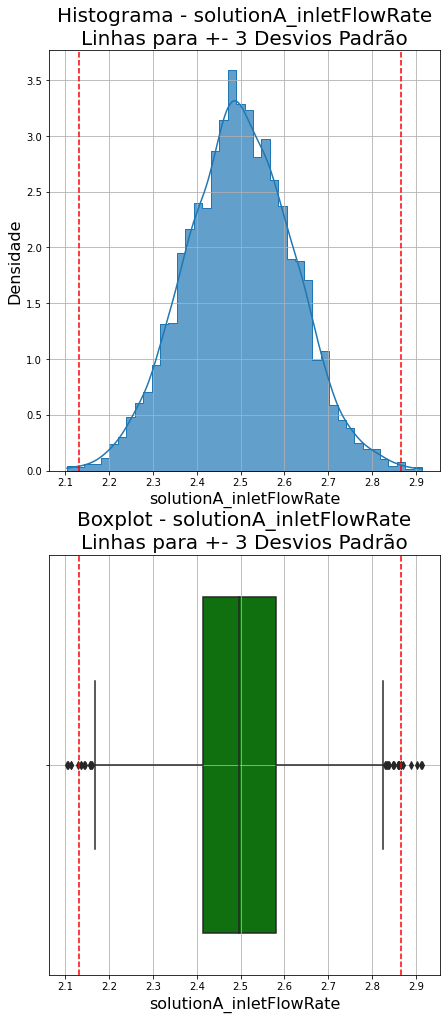

In [9]:
var_name = data.columns[0]
hist_boxplot(data, var_name)

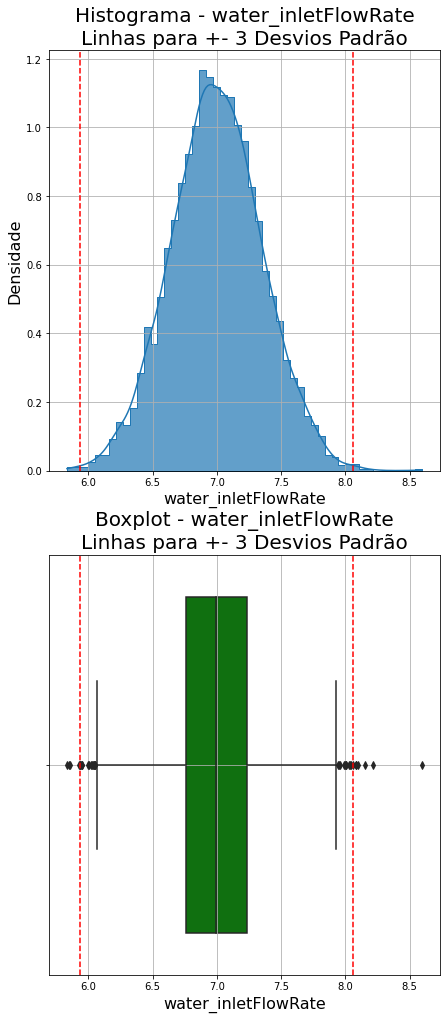

In [10]:
var_name = data.columns[1]
hist_boxplot(data, var_name)

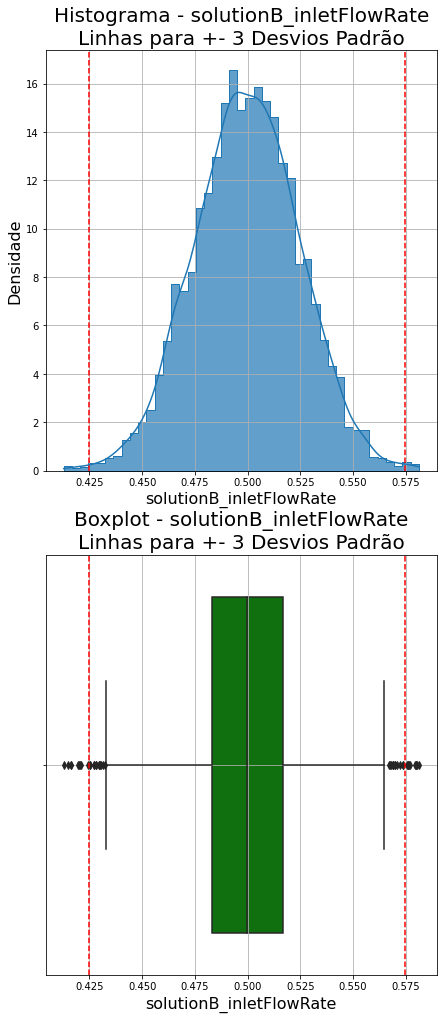

In [11]:
var_name = data.columns[2]
hist_boxplot(data, var_name)

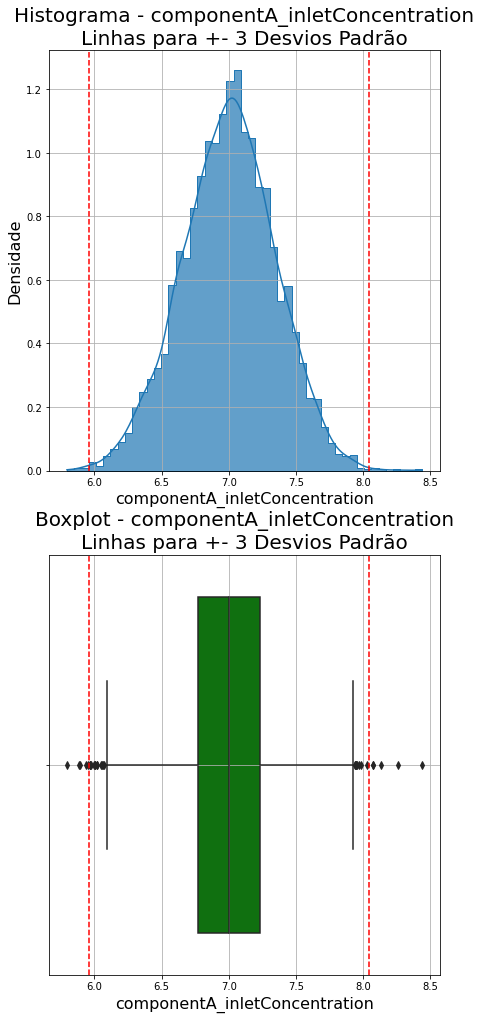

In [12]:
var_name = data.columns[3]
hist_boxplot(data, var_name)

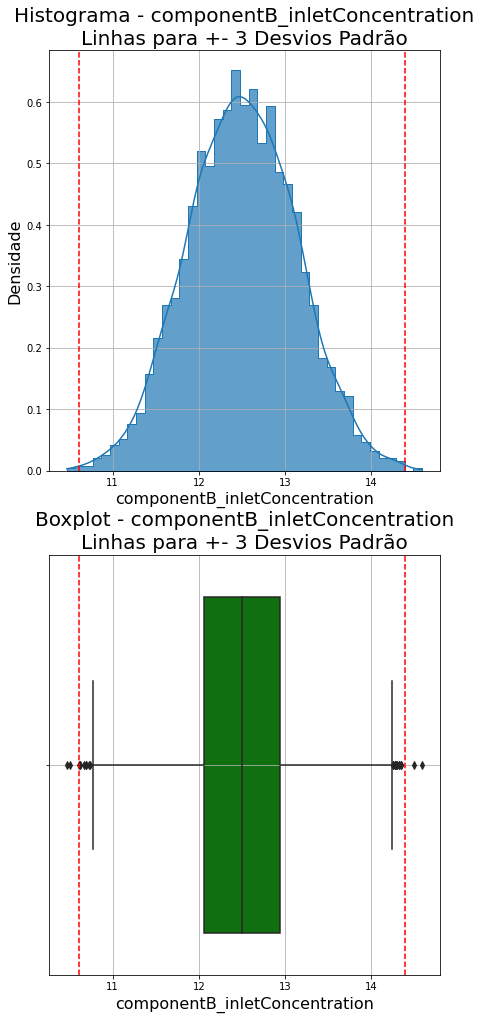

In [13]:
var_name = data.columns[4]
hist_boxplot(data, var_name)

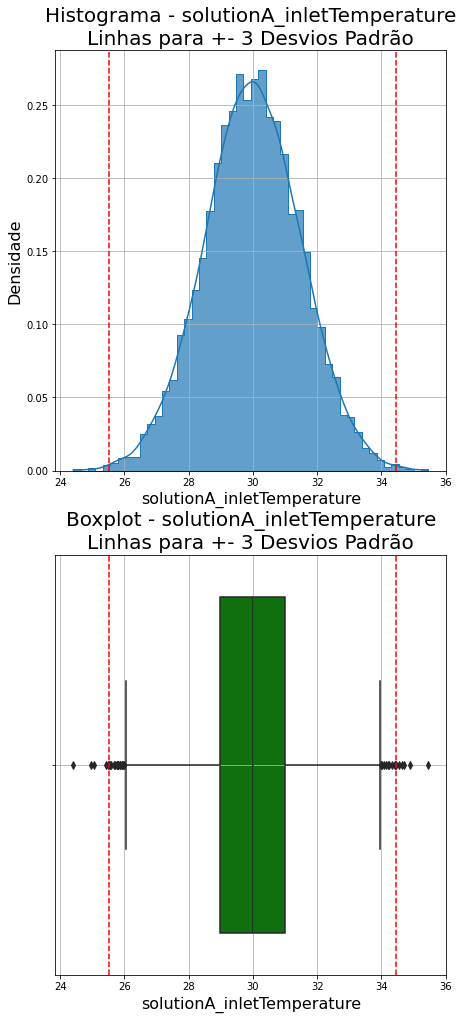

In [14]:
var_name = data.columns[5]
hist_boxplot(data, var_name)

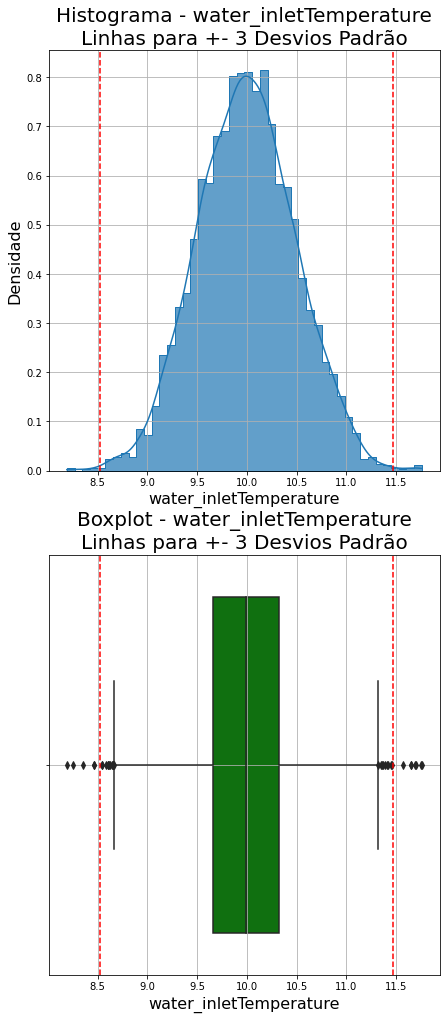

In [15]:
var_name = data.columns[6]
hist_boxplot(data, var_name)

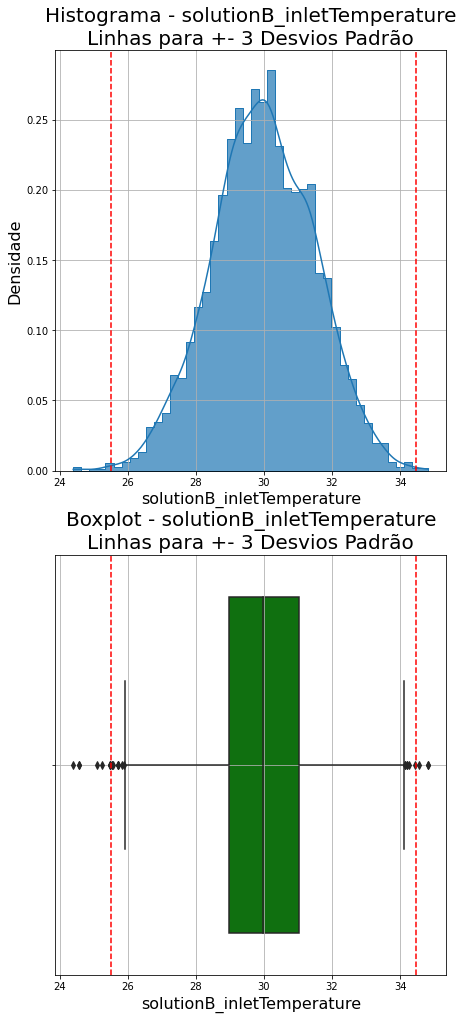

In [16]:
var_name = data.columns[7]
hist_boxplot(data, var_name)

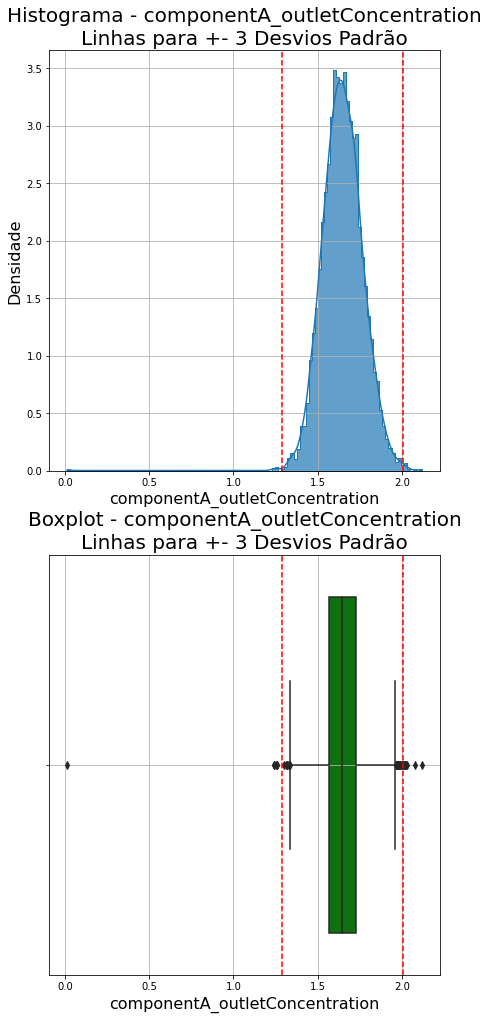

In [17]:
var_name = data.columns[8]
hist_boxplot(data, var_name)

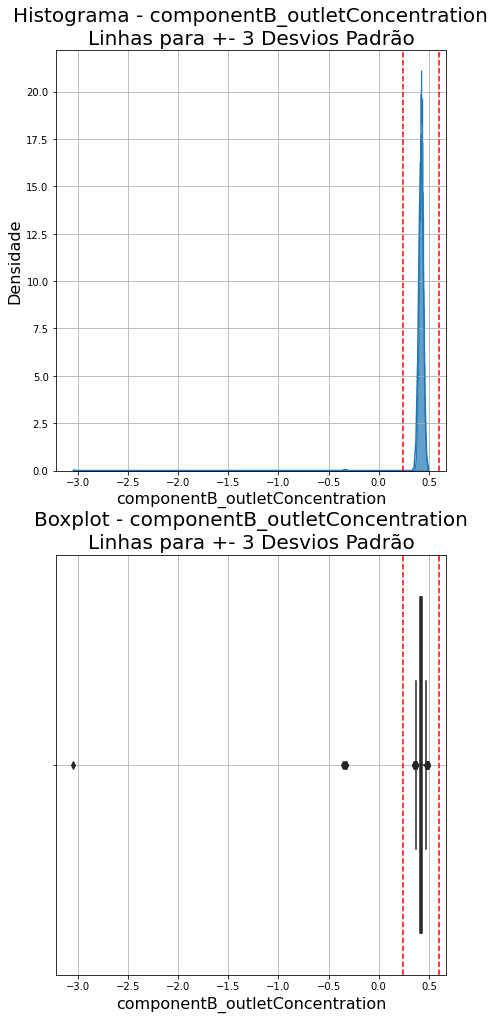

In [18]:
var_name = data.columns[9]
hist_boxplot(data, var_name)

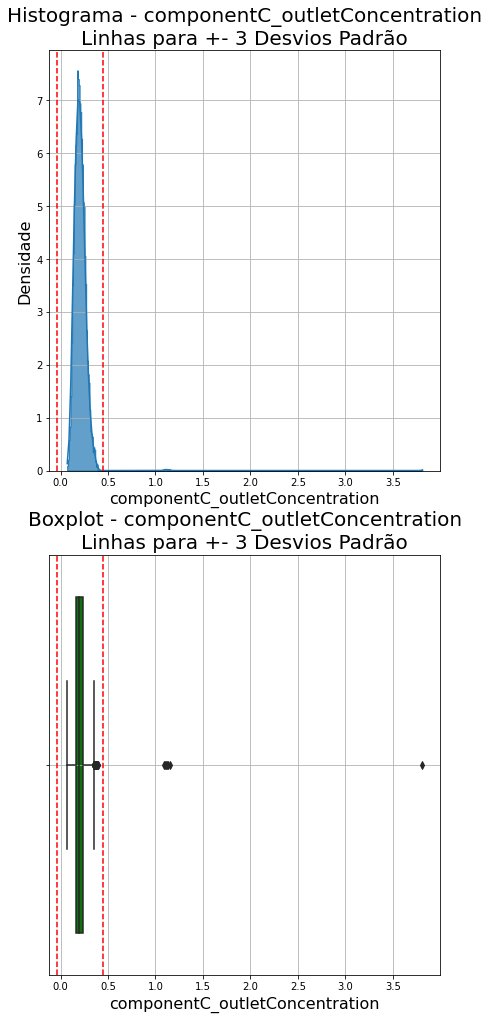

In [19]:
var_name = data.columns[10]
hist_boxplot(data, var_name)

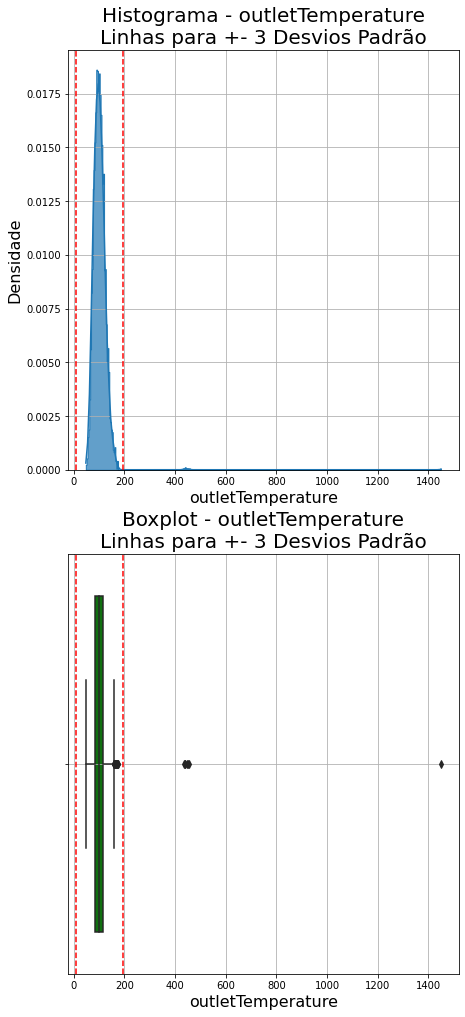

In [20]:
var_name = data.columns[11]
hist_boxplot(data, var_name)

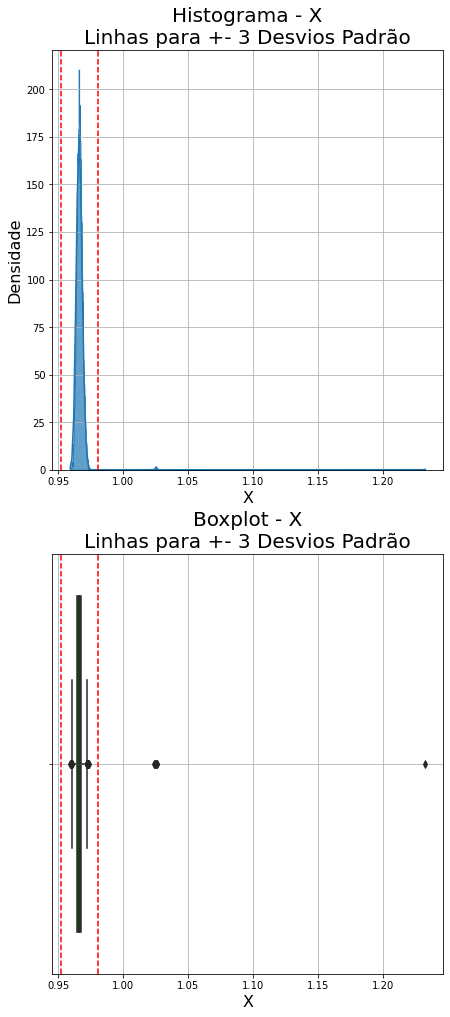

In [21]:
var_name = data.columns[12]
hist_boxplot(data, var_name)

Como se pode verificar, todas as variáveis possuem *outliers* na sua distribuição, inclusive alguns desses valores distorcendo bastante a distribuição dos dados.

É necessário realizar o tratamento dos dados. Para isso, os valores serão substituídos pela média, visto que todas as distribuições são simétricas.

In [22]:
def data_treatment(data, var_name):
  # identificando os limites superior e inferior da coluna desejada
  serie = data[var_name]

  # calculando os quartis 
  q1 = np.quantile(serie, 0.25)
  q3 = np.quantile(serie, 0.75)

  # intervalo interquartílico
  iqr = q3 - q1

  # calculo dos limites máximo e mínimo
  lim_sup = q3 + (1.5*iqr)
  lim_inf = q1 - (1.5*iqr)

  # corrigindo os valores outlier com a média da coluna
  data[var_name].loc[(data[var_name] > lim_sup) | (data[var_name] < lim_inf)] = data[var_name].median()

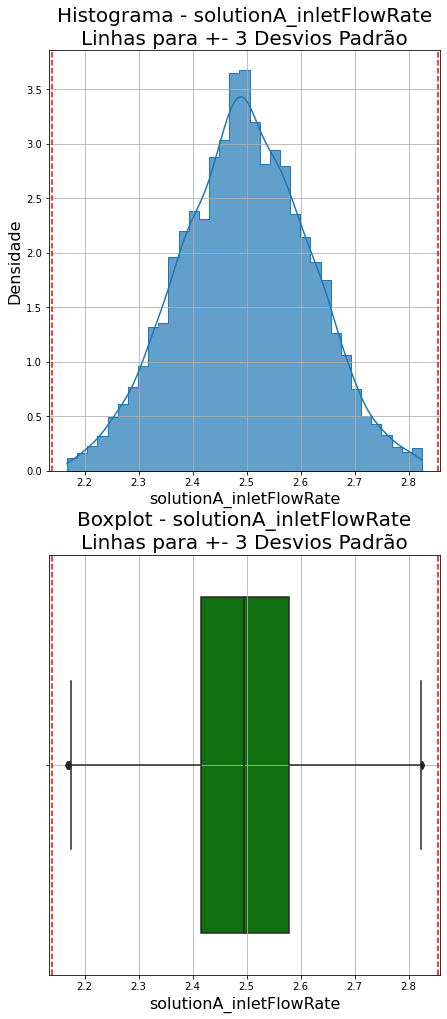

In [23]:
var_name = data.columns[0]
data_treatment(data, var_name)
hist_boxplot(data, var_name)

In [24]:
# uma vez testada, a função pode ser aplicada para todas as outras colunas da base de dados
columns_list = data.columns
print(columns_list)

for column in columns_list:
  data_treatment(data, column)

Index(['solutionA_inletFlowRate', 'water_inletFlowRate',
       'solutionB_inletFlowRate', 'componentA_inletConcentration',
       'componentB_inletConcentration', 'solutionA_inletTemperature',
       'water_inletTemperature', 'solutionB_inletTemperature',
       'componentA_outletConcentration', 'componentB_outletConcentration',
       'componentC_outletConcentration', 'outletTemperature', 'X'],
      dtype='object')


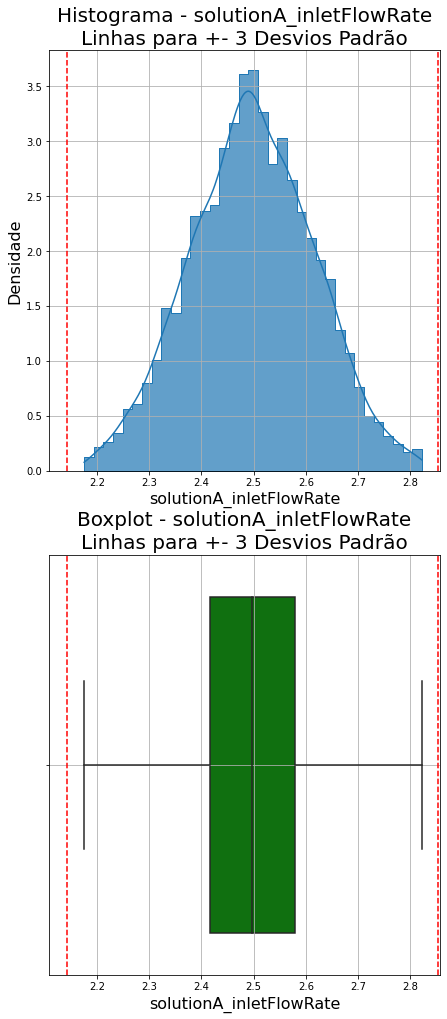

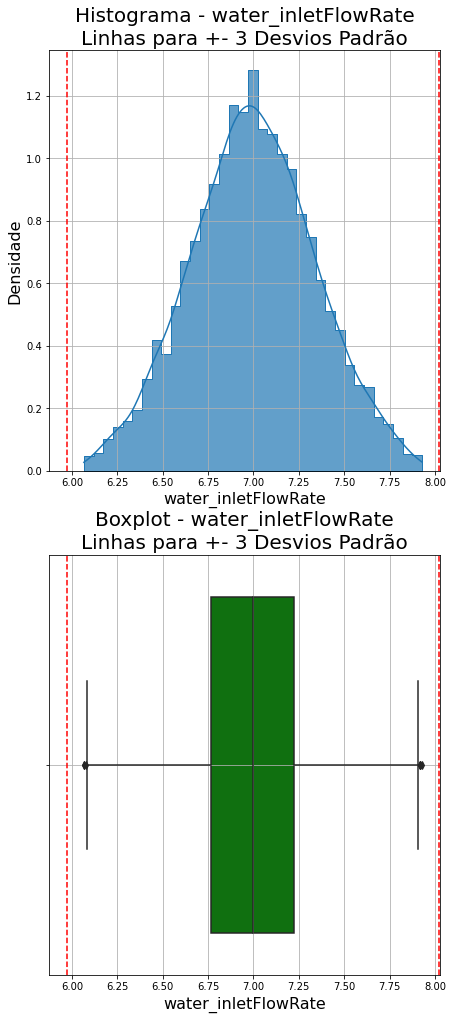

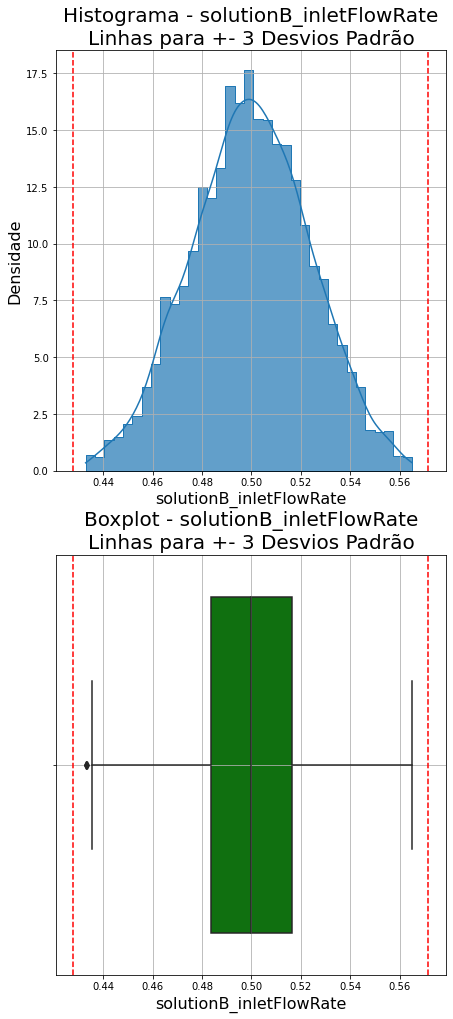

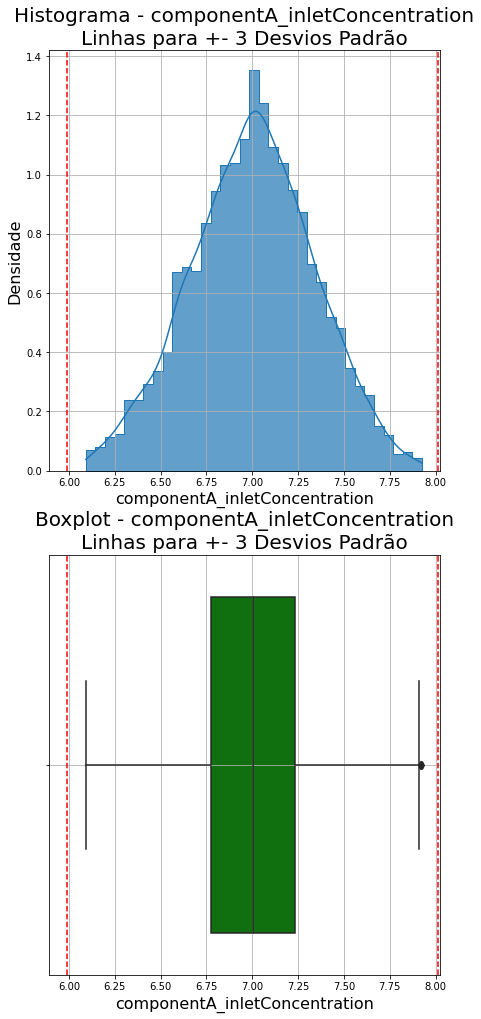

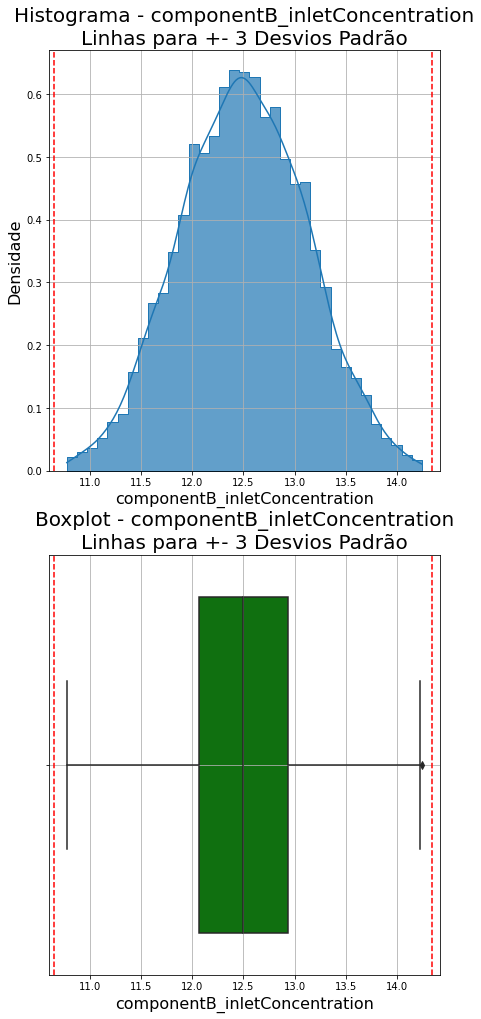

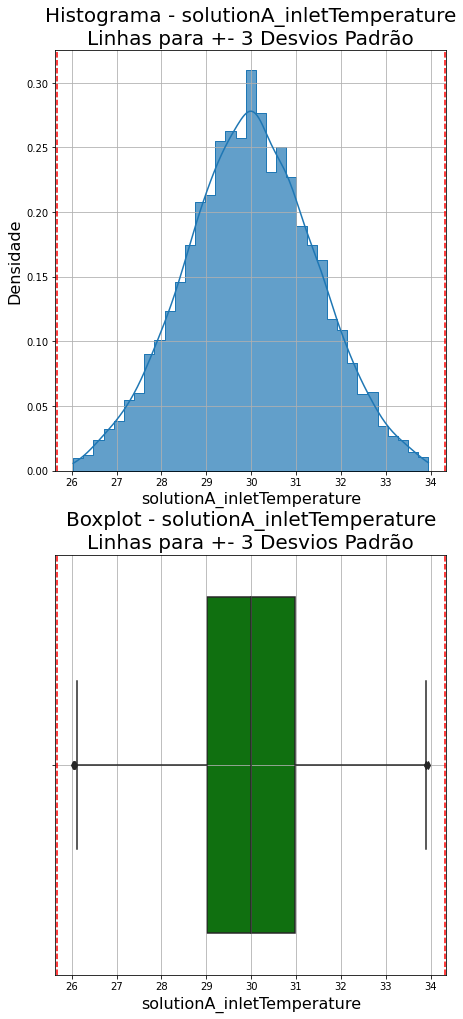

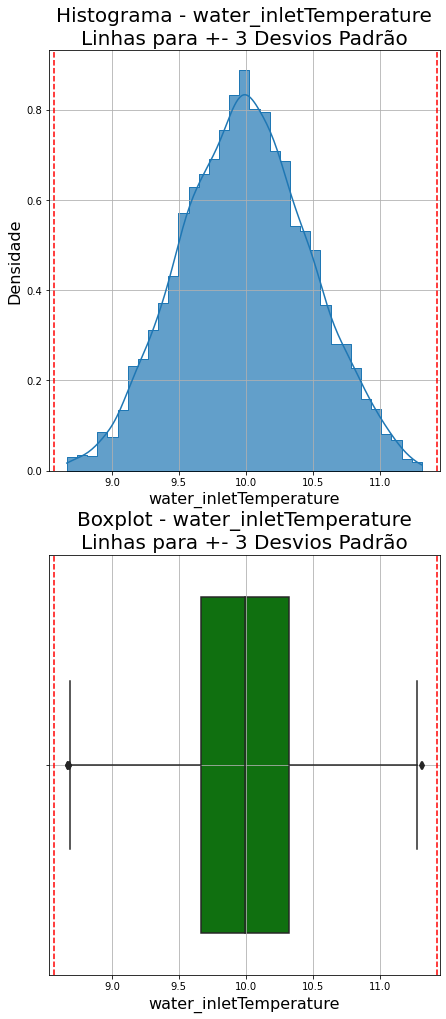

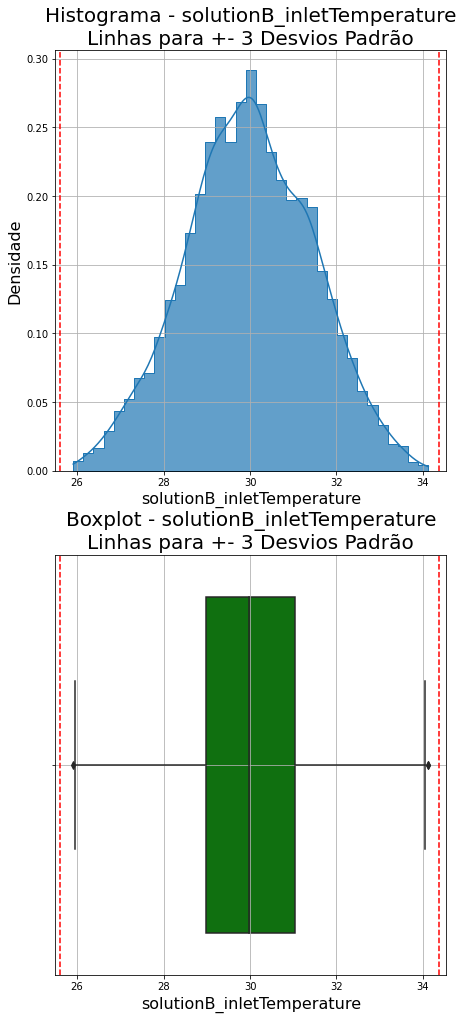

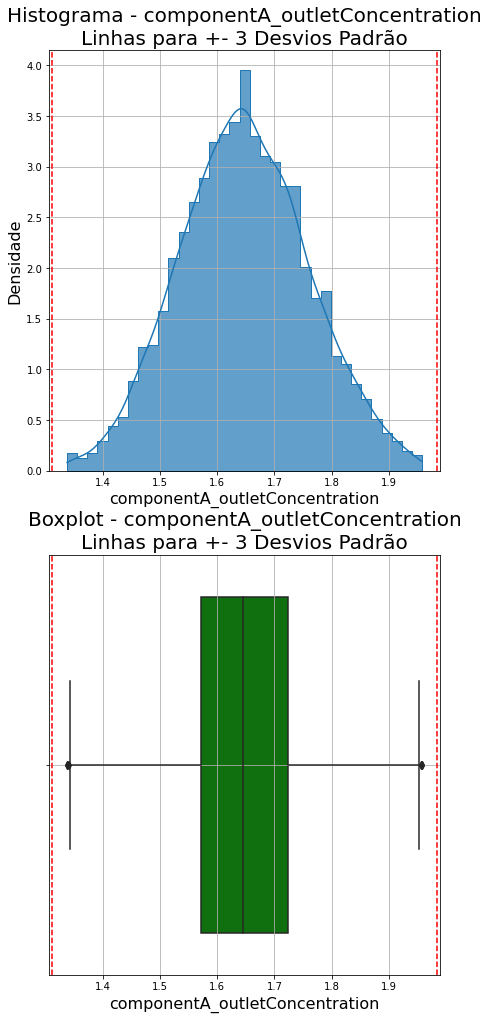

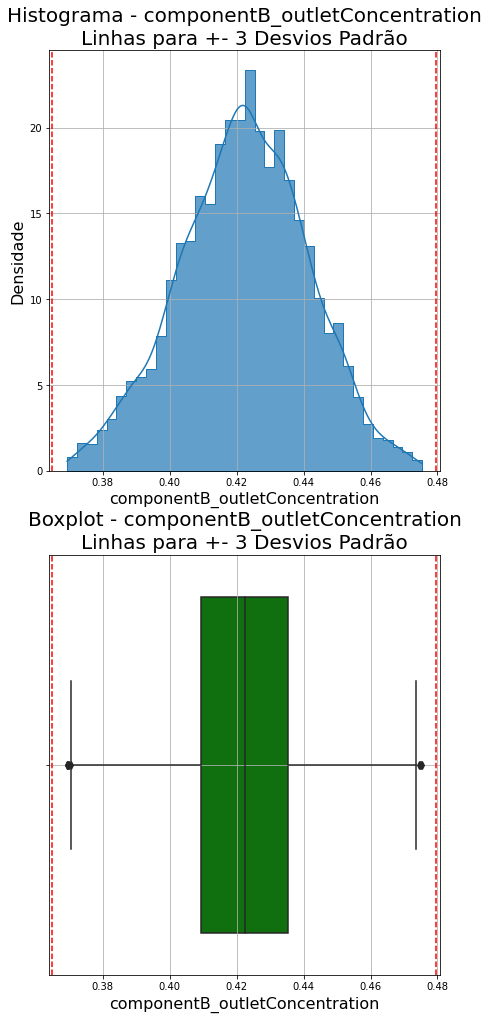

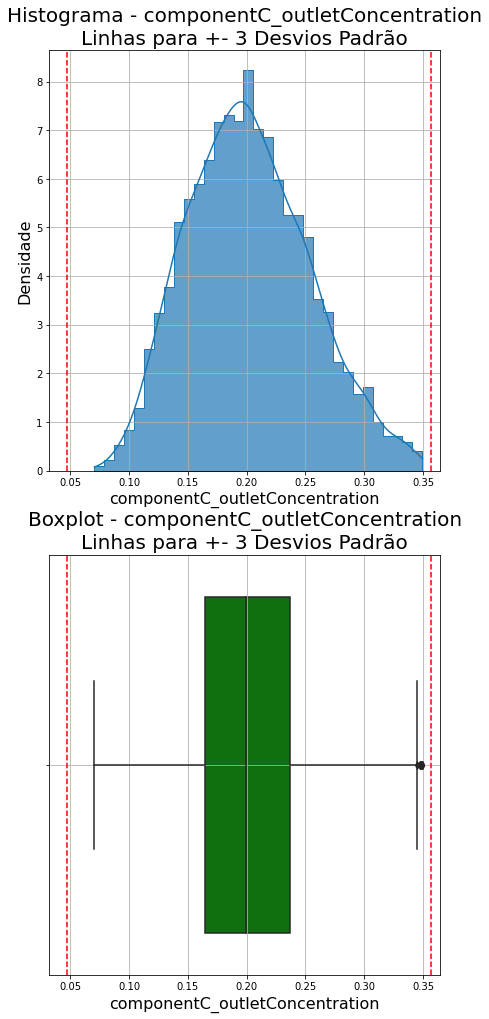

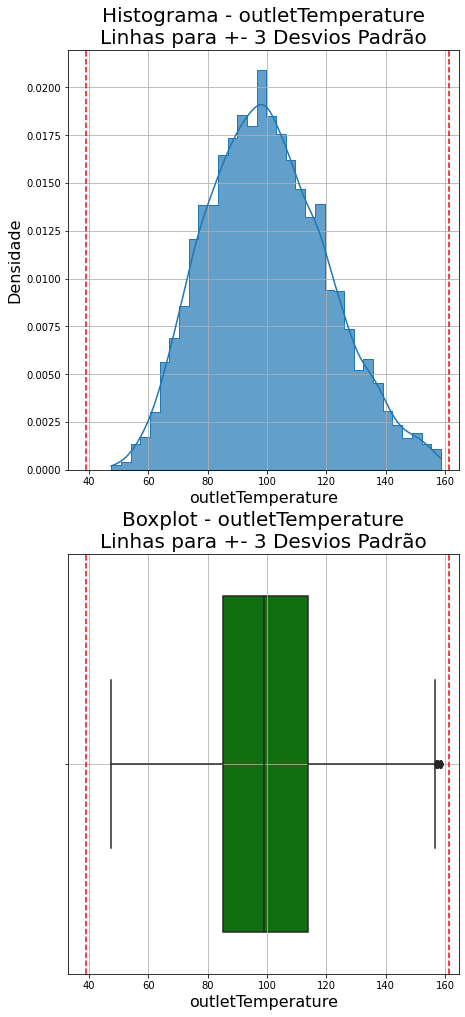

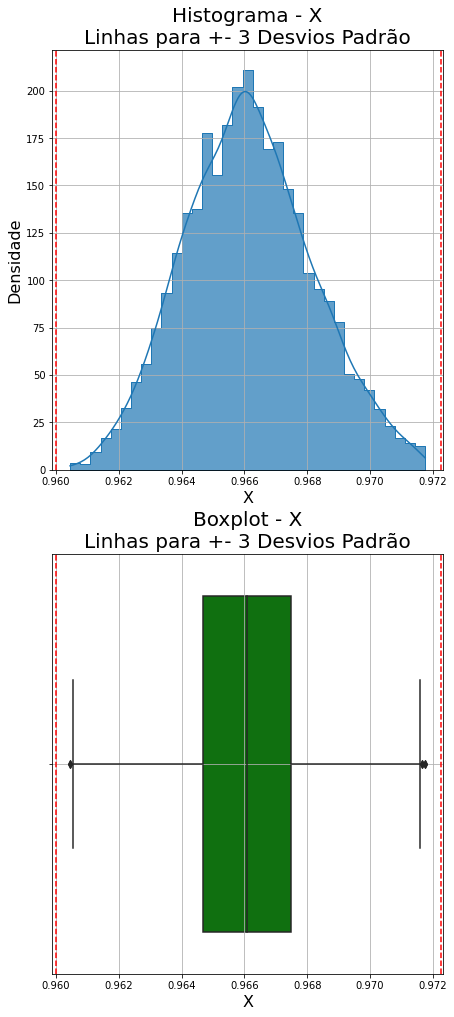

In [25]:
# checando as modificações
for column in columns_list:
  hist_boxplot(data, column)

Conforme observado nos gráficos de histograma e *boxplot* existem alguns pontos ainda acima dos limites superior e abaixo do limite inferior. No entanto, todos se encontram dentro dos limites de +- desvios padrão, o que descarta a possibilidade de serem *outliers*

Dessa forma, conclui-se a etapa de pré-processamento dos dados. O próximo passo é estudar as correlações entre as variáveis de processo coletadas.

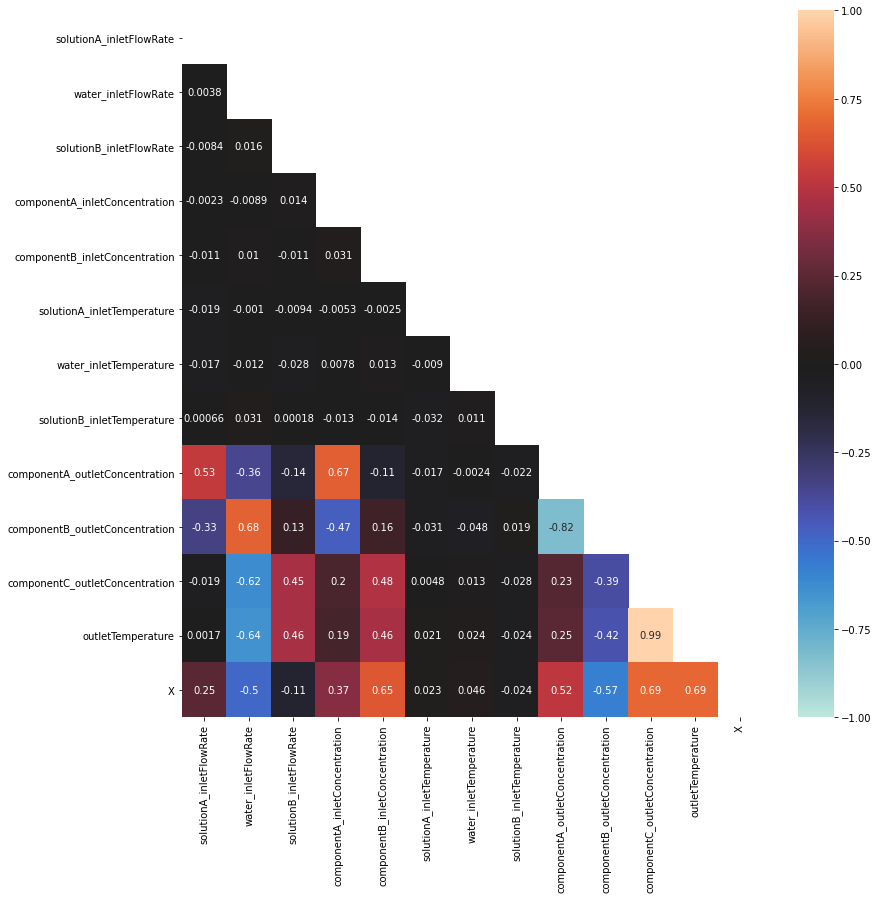

In [26]:
# calculando a matriz de correlação 
corr = data.corr()

# criando a máscara para construção da matriz
mask = np.triu(np.ones_like(corr, dtype=bool))

# plotando a matriz de correlação
plt.figure(figsize = (13,13))
sns.heatmap(corr, mask=mask, vmax=1, center=0, vmin = -1, annot = True)

Observando a matriz de correlação construídos, verifica-se que as variáveis de entrada do processo são indepedentes entre si, pois todos os coeficientes de correlação são bem próximos de zero.

Por outro lado, existem correlações significativas entre as variáveis de entrada e as variáveis de saída, conforme esperado pelos princípios físico químicos que guiam os processos reacionais.

Sobre as correlações observadas, podemos levantar as seguintes notas:

- **Concentração de Saída do Componente A**: influenciada positivamente pela vazão de entrada de componente A e pela concentração de componente A e negativamente pela vazão de entrada de água.
- **Concentração de Saída do Componente B**: influenciada positivamente vazão de entrada de água e negativamente pela vazão de componente A e pela concentração de componente A
- **Concentração de Saída do Componente C**: influenciada positivamente pela vazão de entrada de componente B e pela concentração de componente B na entrada. Influenciado negativamente pela vazão de entrada de água
- **Temperatura de Saída**: semelhante à observação feita para a concentração de saída do componente C
- **Conversão**: influenciada positivamente pela vazão de entrada do componente A, pela concentração de entrada do componente A e pelo concentração de entrada do componente B. Influenciada negativamente pela vazão de entrada de água e pela vazão de entrada do componente B.

É interessante observar existem correlações entre as próprias variáveis de saída. Com base nessa observação, podem-se traçar as seguintes observações:

- **Concentração de saída de componente A**: correlação negativa com a concentração de saída do componente B. Correlação positiva com a concentração de saída do componente C, com a temperatura de saída e com a conversão
- **Concentração de saída de componente B**: além da correlação já mencionada com, possui correlação negativa com a concentração de saída do componente C, com a temperatura de saída e com a conversão
- **Concentração de saída de componente C**: possui forte correlação positiva com a temperatura de saída e com a conversão

Depois de identificar as principais correlações entre as variáveis, vamos entender qual é o formato dessas relações, por meio dos gráficos de dispersão. Para tanto, será selecionado, para cada variável de interesse, as variáveis que apresentaram maior coeficiente de correlação.

### **2.1. Concentração de Saída  do Componente A** 

In [41]:
# estabelecimento do limite de correlação mínima que se deseja visualizar e seleção da variável
thres = 0.2
elec_var = 'componentA_outletConcentration'

def scatter_analysis(data, elec_var, thres):
  # cálculo da matriz de correlação e seleção da coluna correta
  corr_mat = pd.DataFrame(data.corr()[elec_var].reset_index())
  corr_mat.columns = ['var','corr']

  # seleção das variáveis que superam o limite mínimo de correlação
  elec_corr = list(corr_mat.loc[abs(corr_mat['corr'])>thres]['var'])

  # construção dos gráficos de dispersão
  ncol = 3
  nlin = len(elec_corr)//3 + 1
  i = 1

  plt.figure(figsize = (15,13))
  for col in elec_corr:
    plt.subplot(nlin, ncol, i)
    plt.scatter(x = col, y = elec_var, marker = '.', data = data, color = 'black')
    plt.xlabel(col)
    plt.ylabel(elec_var)
    plt.grid()

    if i == 2:
      plt.title('Gráficos de Dispersão - ' + elec_var + 
                '\nNível de correlação mínima: ' + str(thres) + '\n',
                fontsize = 24)

    i += 1

  plt.show()

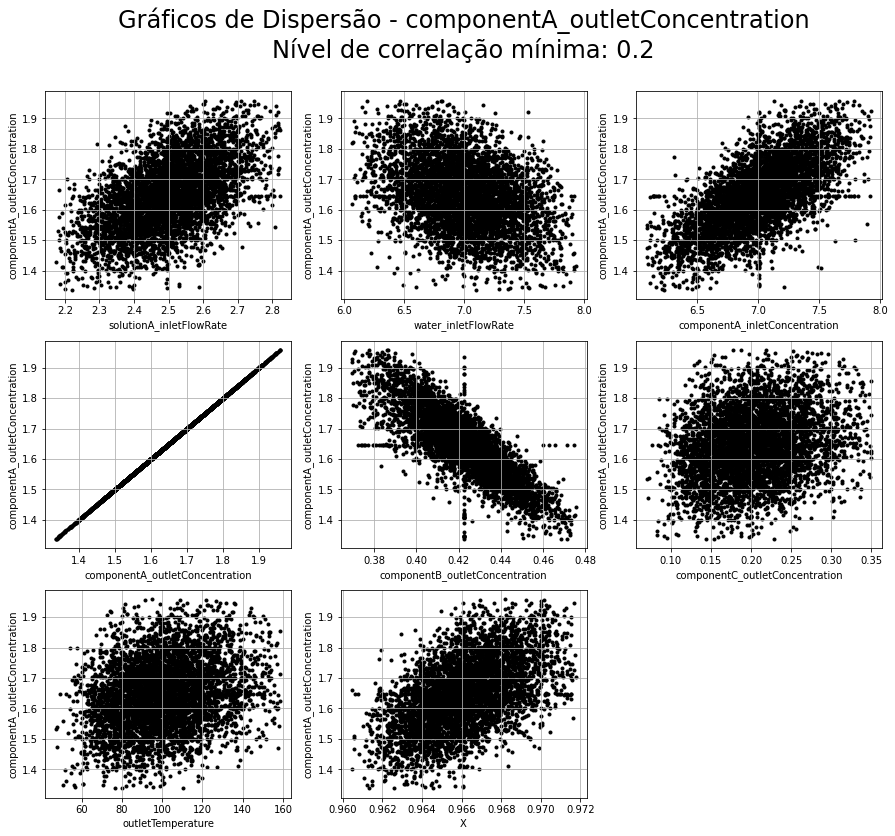

In [42]:
scatter_analysis(data, elec_var, thres)

### **2.2. Concentração de Saída do Componente B**

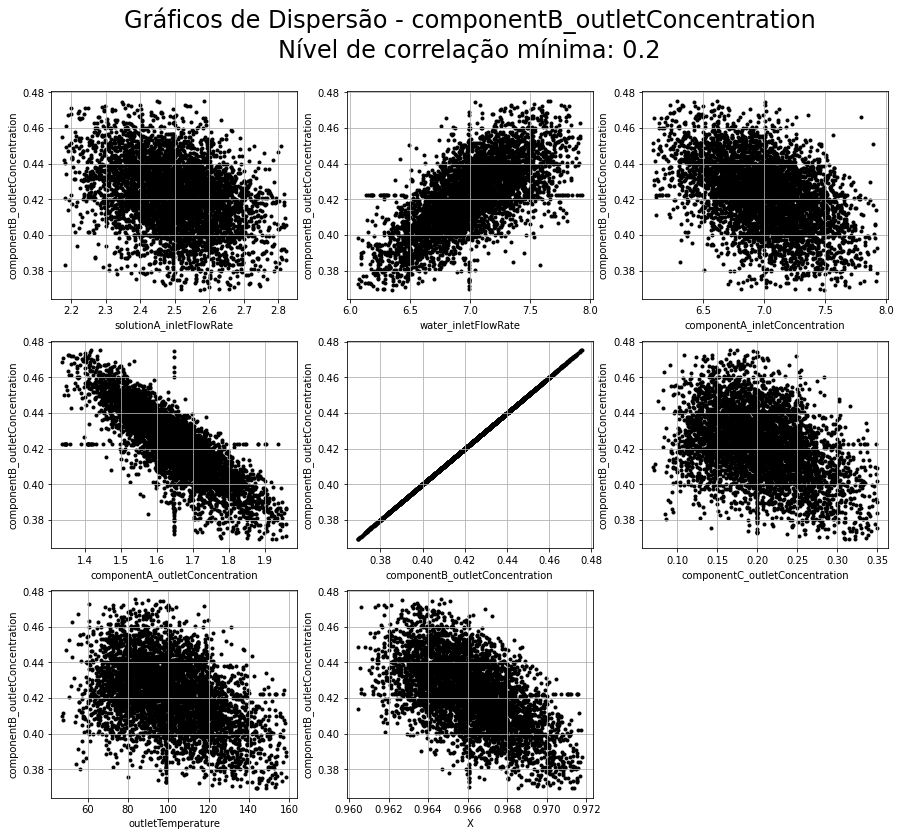

In [43]:
thres = 0.2
elec_var = 'componentB_outletConcentration'
scatter_analysis(data, elec_var, thres)

### **2.3. Concentração de Saída do Componente C**

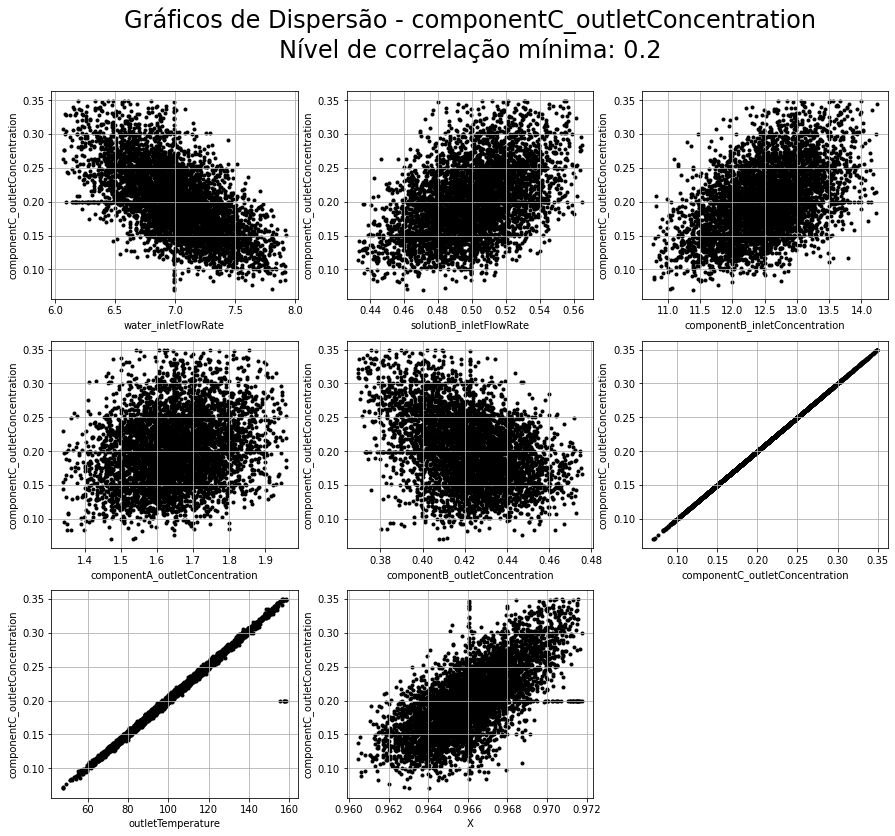

In [44]:
thres = 0.2
elec_var = 'componentC_outletConcentration'
scatter_analysis(data, elec_var, thres)

### **2.4. Temperatura de Saída**

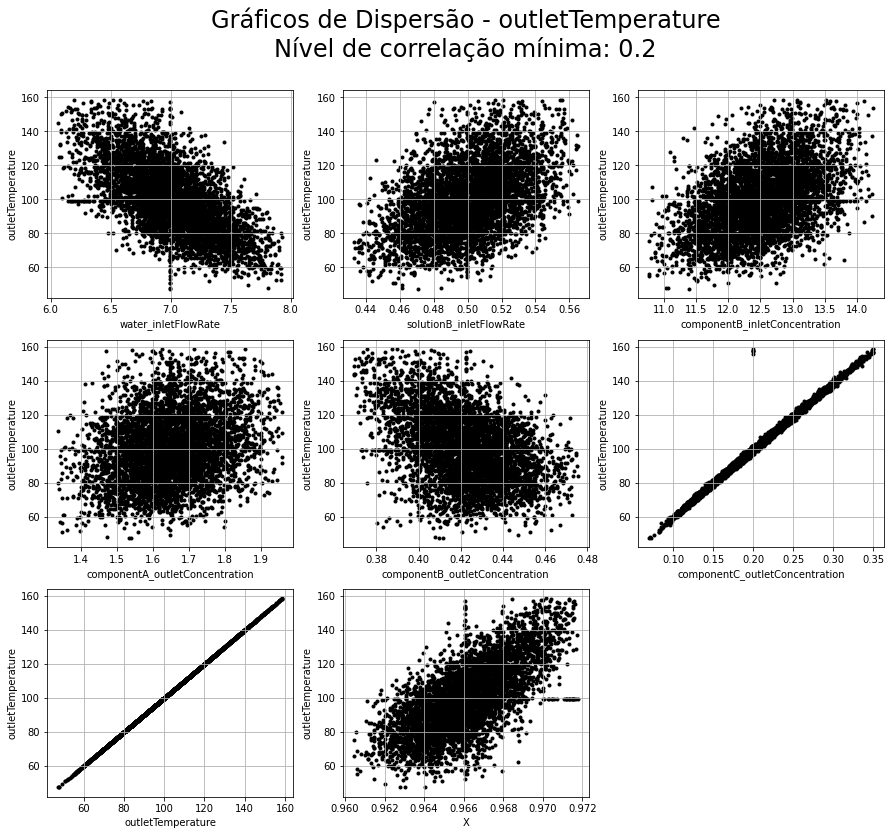

In [45]:
thres = 0.2
elec_var = 'outletTemperature'
scatter_analysis(data, elec_var, thres)

### **2.5. Conversão**

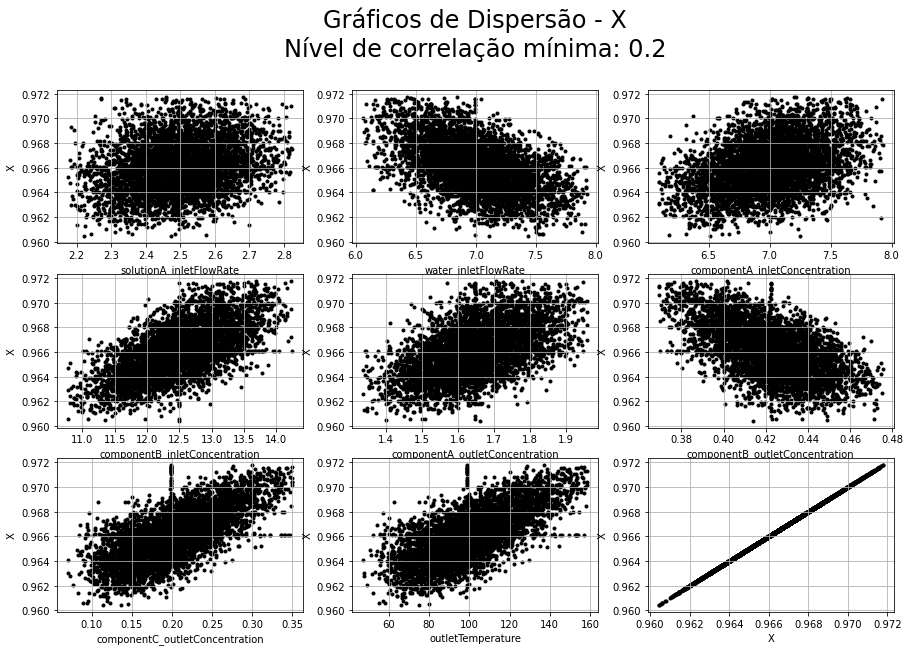

In [46]:
thres = 0.2
elec_var = 'X'
scatter_analysis(data, elec_var, thres)